In [55]:
import tensorflow as tf
from tensorflow.keras.models import load_model

from PIL import Image as PILImage

import cv2
import numpy as np
import glob
import os

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import Sequence

from keras.layers import Layer

import csv
import pandas as pd

from annoy import AnnoyIndex

In [56]:
IMAGE_SIZE = (256, 256)

In [57]:
def imshow(a, size=1.0):
    # Clip and convert the image to uint8
    a = a.clip(0, 255).astype("uint8")
    
    # Resize the image if a size factor is provided
    if size != 1.0:
        new_dim = (int(a.shape[1] * size), int(a.shape[0] * size))
        a = cv2.resize(a, new_dim, interpolation=cv2.INTER_AREA)
    
    # Display the image
    display(PILImage.fromarray(a))

In [58]:
data_folder = "Data/*"
image_files = glob.glob(os.path.join(data_folder, "*.jpg"), recursive=True)

In [59]:
class L2Normalization(Layer):
    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=1)

In [60]:
model = load_model("Models/embedding_custom_big.keras",
    custom_objects={"L2Normalization": L2Normalization})

In [61]:
def read_image(file_path):
    img = cv2.imread(file_path)
    img = cv2.resize(img, IMAGE_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


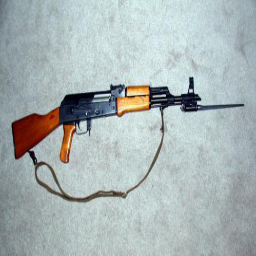

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


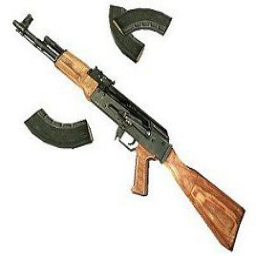

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


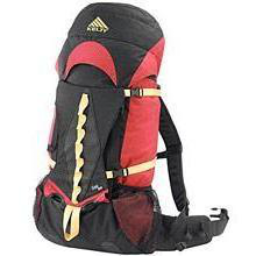

Distance between image 1 and image 2: 0.010120485
Distance between image 1 and image 3: 0.043619078


In [62]:
import tensorflow as tf

img_1 = read_image(image_files[0])
emb_1 = model.predict(np.expand_dims(img_1, axis=0), verbose=1)
imshow(img_1)

img_2 = read_image(image_files[1])
emb_2 = model.predict(np.expand_dims(img_2, axis=0), verbose=1)
imshow(img_2)

img_3 = read_image(image_files[342])
emb_3 = model.predict(np.expand_dims(img_3, axis=0), verbose=1)
imshow(img_3)

dist_1_2 = np.linalg.norm(emb_1 - emb_2)
dist_1_3 = np.linalg.norm(emb_1 - emb_3)

print("Distance between image 1 and image 2:", dist_1_2)
print("Distance between image 1 and image 3:", dist_1_3)

In [64]:
#GENERATE EMBEDDINGS FOR ALL IMAGES AND STORE AS ANNOY FIEL FOR QUCIK SEARCH

embedding_dimensions = 512
index = AnnoyIndex(embedding_dimensions, "angular")  # Use "angular" or "euclidean" as needed


# Embedding extraction loop
for i, file_path in enumerate(image_files):
    img = read_image(file_path)
    emb = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]
    emb = np.array(emb)
    
    # Add the embedding to the Annoy index
    index.add_item(i, emb)
    
    if (i + 1) % 500 == 0:
        print(f"Processed {i + 1} of {len(image_files)}")

# Build the index (You can change the number of trees to optimize for memory/speed)
index.build(10)

# Save the Annoy index to a file
index_file = "Annoys/embeddings_index_custom_big.ann"
index.save(index_file)

print(f"Annoy index saved to {index_file}")

Processed 500 of 30607
Processed 1000 of 30607
Processed 1500 of 30607
Processed 2000 of 30607
Processed 2500 of 30607
Processed 3000 of 30607
Processed 3500 of 30607
Processed 4000 of 30607
Processed 4500 of 30607
Processed 5000 of 30607
Processed 5500 of 30607
Processed 6000 of 30607
Processed 6500 of 30607
Processed 7000 of 30607
Processed 7500 of 30607
Processed 8000 of 30607
Processed 8500 of 30607
Processed 9000 of 30607
Processed 9500 of 30607
Processed 10000 of 30607
Processed 10500 of 30607
Processed 11000 of 30607
Processed 11500 of 30607
Processed 12000 of 30607
Processed 12500 of 30607
Processed 13000 of 30607
Processed 13500 of 30607
Processed 14000 of 30607
Processed 14500 of 30607
Processed 15000 of 30607
Processed 15500 of 30607
Processed 16000 of 30607
Processed 16500 of 30607
Processed 17000 of 30607
Processed 17500 of 30607
Processed 18000 of 30607
Processed 18500 of 30607
Processed 19000 of 30607
Processed 19500 of 30607
Processed 20000 of 30607
Processed 20500 of 3